In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
train_out_dir = '../../02_train/out/'
test_out_dir = '../../04_test/out/'

# data, primarily for the ice flags
train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'
soft_test_data_fpath = process_out_dir + 'soft_test_data.npz'
test_data_fpath = process_out_dir + 'test_data.npz'

# associated predictions
remove_PB = True
if remove_PB:
    train_preds_fpath = train_out_dir + 'massive_lstm_train_preds_0_NoProcessBasedInput_.npy'
    valid_preds_fpath = train_out_dir + 'massive_lstm_valid_preds_0_NoProcessBasedInput_.npy'
    soft_test_preds_fpath = test_out_dir + 'massive_lstm_soft_test_preds_0_NoProcessBasedInput_.npy'
    test_preds_fpath = test_out_dir + 'massive_lstm_test_preds_0_NoProcessBasedInput_.npy'
    eval_metrics_fpath = '../out/massive_lstm_test_metrics_0_NoProcessBasedInput_.npz'
else:
    train_preds_fpath = train_out_dir + 'massive_lstm_train_preds_1_.npy'
    valid_preds_fpath = train_out_dir + 'massive_lstm_valid_preds_1_.npy'
    soft_test_preds_fpath = test_out_dir + 'massive_lstm_soft_test_preds_1_.npy'
    test_preds_fpath = test_out_dir + 'massive_lstm_test_preds_1_.npy'
    eval_metrics_fpath = '../out/massive_lstm_test_metrics_1_.npz'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

# Import data

In [3]:
# Import all partitions - train & valid will only be used for ice free days
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)
soft_test_data = np.load(soft_test_data_fpath, allow_pickle = True)
test_data = np.load(test_data_fpath, allow_pickle = True)

# Extract everything from training partition
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

# Extract everything from validation partition
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

# Extract everything from soft testing partition
soft_test_x = soft_test_data['x']
soft_test_y = soft_test_data['y']
soft_test_dates = soft_test_data['dates']
soft_test_DOW = soft_test_data['DOW']
soft_test_variables = soft_test_data['features']

# Extract everything from testing partition
test_x = test_data['x']
test_y = test_data['y']
test_dates = test_data['dates']
test_DOW = test_data['DOW']
test_variables = test_data['features']

# Import associated predictions
train_preds = np.load(train_preds_fpath)
valid_preds = np.load(valid_preds_fpath)
soft_test_preds = np.load(soft_test_preds_fpath)
test_preds = np.load(test_preds_fpath)

In [4]:
# Separate the two types of soft testing data
train_years_test_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] < test_data['dates'].min()).flatten()
test_years_train_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] >= test_data['dates'].min()).flatten()

train_years_test_lakes_preds = soft_test_preds[train_years_test_lakes_ids]
train_years_test_lakes_x = soft_test_x[train_years_test_lakes_ids]
train_years_test_lakes_y = soft_test_y[train_years_test_lakes_ids]
train_years_test_lakes_dates = soft_test_dates[train_years_test_lakes_ids]

test_years_train_lakes_preds = soft_test_preds[test_years_train_lakes_ids]
test_years_train_lakes_x = soft_test_x[test_years_train_lakes_ids]
test_years_train_lakes_y = soft_test_y[test_years_train_lakes_ids]
test_years_train_lakes_dates = soft_test_dates[test_years_train_lakes_ids]

In [5]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(test_variables == 'ice'))
depth_var_idx = int(np.argwhere(test_variables == 'MaxDepth'))
area_var_idx = int(np.argwhere(test_variables == 'LakeArea'))
assert train_variables[ice_var_idx] == 'ice'
assert train_variables[depth_var_idx] == 'MaxDepth'
assert train_variables[area_var_idx] == 'LakeArea'
assert valid_variables[ice_var_idx] == 'ice'
assert valid_variables[depth_var_idx] == 'MaxDepth'
assert valid_variables[area_var_idx] == 'LakeArea'
assert soft_test_variables[ice_var_idx] == 'ice'
assert soft_test_variables[depth_var_idx] == 'MaxDepth'
assert soft_test_variables[area_var_idx] == 'LakeArea'

In [6]:
eval_metrics = np.load(eval_metrics_fpath, allow_pickle = True)

# Plot some simple time series

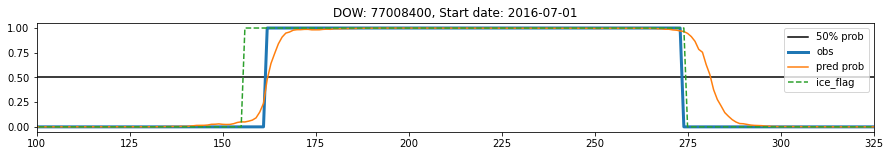

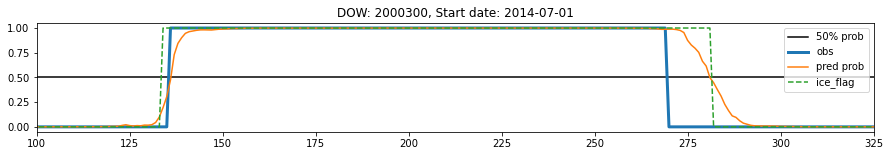

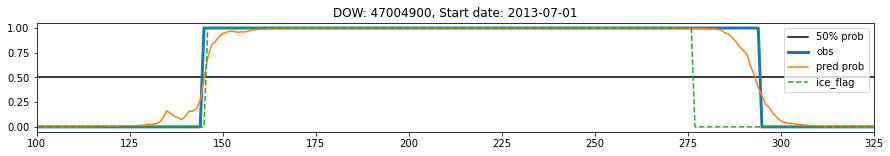

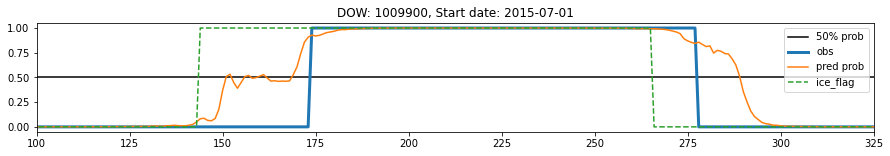

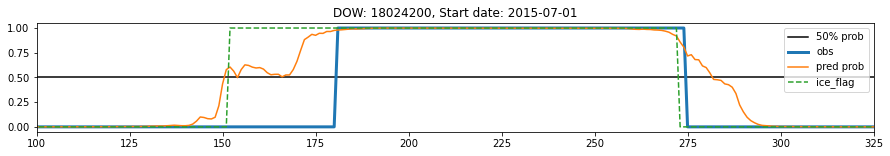

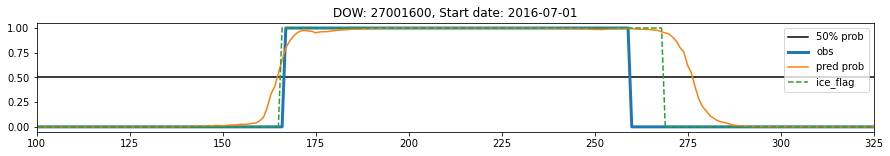

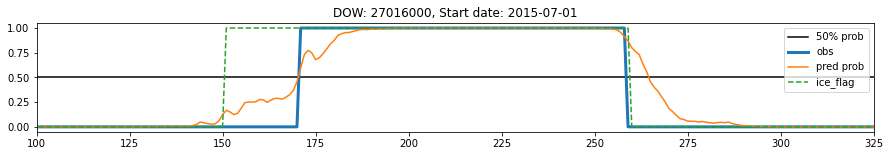

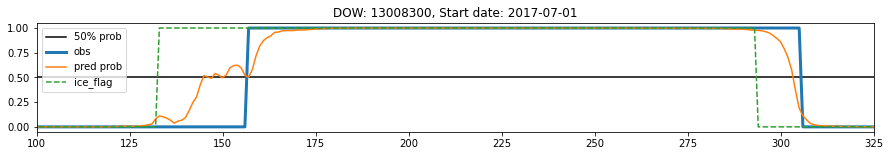

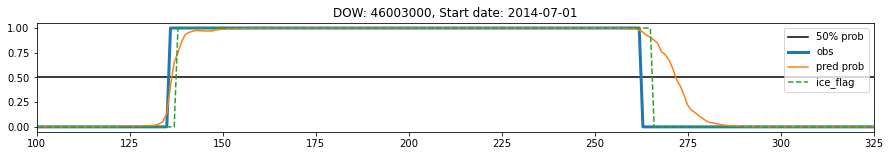

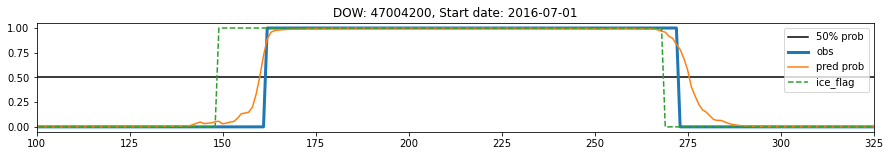

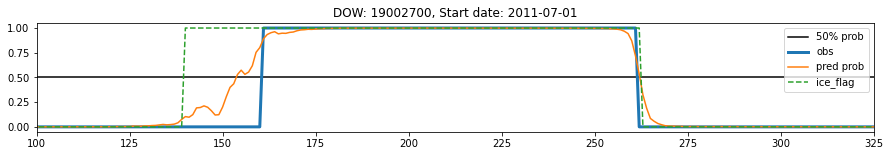

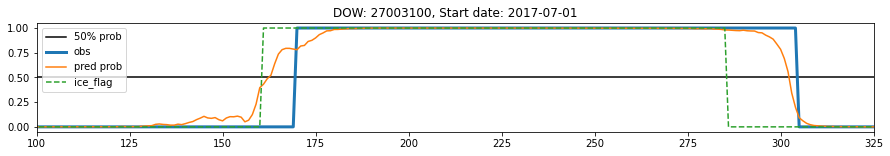

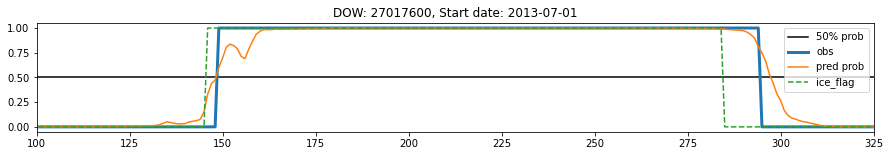

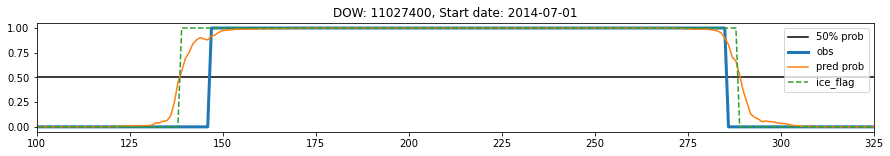

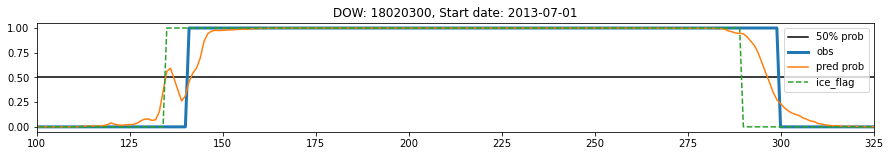

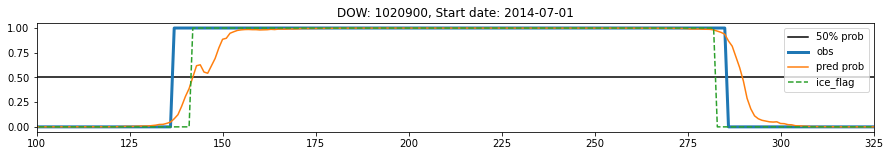

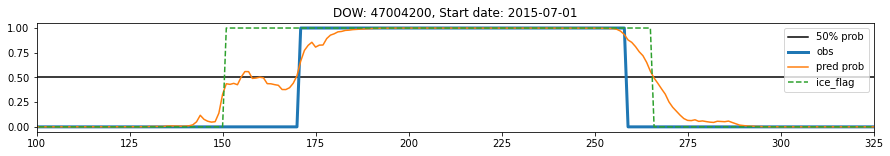

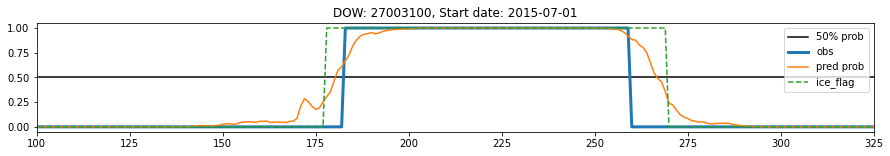

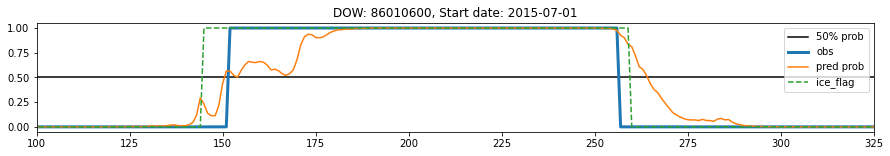

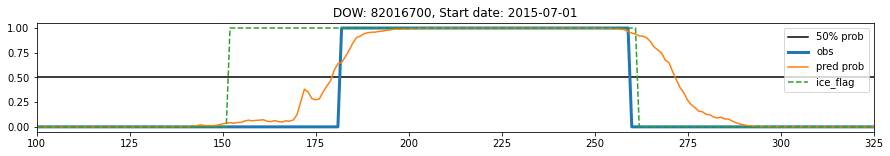

In [7]:
# Seed to view the same ones each time
np.random.seed(123)

# 10 random time series plots
# Includes:
#   Observation
#   Prediction
#   PB ice flag
#   50% probability line
#   Date and DOW of time series
for i in range(20):
    rand_i = np.random.choice(test_preds.shape[0])

    plt.figure(figsize = (15, 2))
    plt.axhline(0.5, label = '50% prob', color = 'black')
    plt.plot(test_y[rand_i, :], label = 'obs', linewidth = 3)
    plt.plot(test_preds[rand_i, :, 0], label = 'pred prob')
    plt.plot(test_x[rand_i, :, ice_var_idx], label = 'ice_flag', linestyle = '--')
    plt.title('DOW: ' + str(test_DOW[rand_i]) + ', Start date: ' + test_dates[rand_i][0])
    plt.xlim(100, 325)
    plt.legend();

# Ice free days through time

In [8]:
ice_on_cutoff = 215

def extract_date_i_and_date(ice_indications, dates):
    
    # ice_on_cutoff is globally defined
    
    ice_on_ids = []
    ice_off_ids = []
    
    ice_on = []
    ice_off = []

    for i in range(ice_indications.shape[0]):
        # Result in +1 when ice emerges and -1 when ice disappears. 0 otherwise.
        diff_i = np.diff(ice_indications[i, :])

        # Indexing by -1 finds the latest/"max" occurrence
        # for ice_on, we need to avoid late season refreeze ice on dates
        ice_on_index = np.argwhere(diff_i == 1)[np.argwhere(diff_i == 1) < ice_on_cutoff][-1].item()
        ice_off_index = np.argwhere(diff_i == -1)[-1].item()

        # Store found indices
        ice_on_ids.append(ice_on_index)
        ice_off_ids.append(ice_off_index)
        
        # Store found dates
        ice_on.append(dates[i, ice_on_index])
        ice_off.append(dates[i, ice_off_index])
        
    return(ice_on_ids, ice_off_ids,
           ice_on, ice_off)

In [9]:
# important dates = last ice on and last ice off
# get important dates and date-indices for observations
### Train
objects = extract_date_i_and_date(train_y, train_dates)
train_obs_ice_on_ids, train_obs_ice_off_ids, train_obs_ice_on, train_obs_ice_off = objects
### Valid
objects = extract_date_i_and_date(valid_y, valid_dates)
valid_obs_ice_on_ids, valid_obs_ice_off_ids, valid_obs_ice_on, valid_obs_ice_off = objects
### Soft test
objects = extract_date_i_and_date(soft_test_y, soft_test_dates)
soft_test_obs_ice_on_ids, soft_test_obs_ice_off_ids, soft_test_obs_ice_on, soft_test_obs_ice_off = objects
### Test
objects = extract_date_i_and_date(test_y, test_dates)
test_obs_ice_on_ids, test_obs_ice_off_ids, test_obs_ice_on, test_obs_ice_off = objects

In [10]:
# get important dates and date-indices for PBM
### Train
objects = extract_date_i_and_date(train_x[:, :, ice_var_idx], train_dates)
train_flag_ice_on_ids, train_flag_ice_off_ids, train_flag_ice_on, train_flag_ice_off = objects
### Train
objects = extract_date_i_and_date(valid_x[:, :, ice_var_idx], valid_dates)
valid_flag_ice_on_ids, valid_flag_ice_off_ids, valid_flag_ice_on, valid_flag_ice_off = objects
### Train
objects = extract_date_i_and_date(soft_test_x[:, :, ice_var_idx], soft_test_dates)
soft_test_flag_ice_on_ids, soft_test_flag_ice_off_ids, soft_test_flag_ice_on, soft_test_flag_ice_off = objects
### Train
objects = extract_date_i_and_date(test_x[:, :, ice_var_idx], test_dates)
test_flag_ice_on_ids, test_flag_ice_off_ids, test_flag_ice_on, test_flag_ice_off = objects

In [11]:
# get important dates and date-indices for LSTM prediction
### Train
objects = extract_date_i_and_date(np.round(train_preds)[:, :, 0], train_dates)
train_pred_ice_on_ids, train_pred_ice_off_ids, train_pred_ice_on, train_pred_ice_off = objects
### Train
objects = extract_date_i_and_date(np.round(valid_preds)[:, :, 0], valid_dates)
valid_pred_ice_on_ids, valid_pred_ice_off_ids, valid_pred_ice_on, valid_pred_ice_off = objects
### Train
objects = extract_date_i_and_date(np.round(soft_test_preds)[:, :, 0], soft_test_dates)
soft_test_pred_ice_on_ids, soft_test_pred_ice_off_ids, soft_test_pred_ice_on, soft_test_pred_ice_off = objects
### Train
objects = extract_date_i_and_date(np.round(test_preds)[:, :, 0], test_dates)
test_pred_ice_on_ids, test_pred_ice_off_ids, test_pred_ice_on, test_pred_ice_off = objects

In [12]:
train_year_of_sequence = np.asarray([int(dates[0].split('-')[0]) for dates in train_data['dates']])
valid_year_of_sequence = np.asarray([int(dates[0].split('-')[0]) for dates in valid_data['dates']])
soft_test_year_of_sequence = np.asarray([int(dates[0].split('-')[0]) for dates in soft_test_data['dates']])
test_year_of_sequence = np.asarray([int(dates[0].split('-')[0]) for dates in test_data['dates']])

In [13]:
import datetime
from scipy.stats import linregress

In [14]:
obs_ice_on = np.concatenate([train_obs_ice_on,
                             valid_obs_ice_on,
                             soft_test_obs_ice_on,
                             test_obs_ice_on])

flag_ice_on = np.concatenate([train_flag_ice_on,
                             valid_flag_ice_on,
                             soft_test_flag_ice_on,
                             test_flag_ice_on])

pred_ice_on = np.concatenate([train_pred_ice_on,
                              valid_pred_ice_on,
                              soft_test_pred_ice_on,
                              test_pred_ice_on])

year_of_sequence = np.concatenate([train_year_of_sequence,
                                   valid_year_of_sequence,
                                   soft_test_year_of_sequence,
                                   test_year_of_sequence])

Observed
	 LinregressResult(slope=0.19626208318794264, intercept=-61.31908054069345, rvalue=0.08073801042806904, pvalue=9.411749727721441e-08, stderr=0.036706624211107756, intercept_stderr=73.4729523633611)


PBM
	 LinregressResult(slope=0.08885080859234948, intercept=147.0902973574082, rvalue=0.08420940355610577, pvalue=2.576334929668779e-08, stderr=0.015928016170580598, intercept_stderr=31.881939527137902)


Predicted
	 LinregressResult(slope=0.16158185197917987, intercept=8.085840766185697, rvalue=0.14549555735562544, pvalue=4.6965594818263295e-22, stderr=0.016645733456082588, intercept_stderr=33.318541477368214)


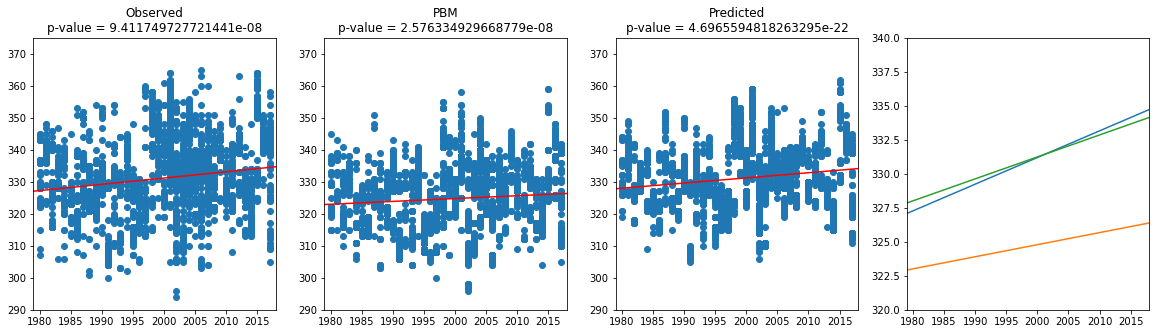

In [15]:
obs_day_of_year_ice_on = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in obs_ice_on
])
flag_day_of_year_ice_on = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in flag_ice_on
])
pred_day_of_year_ice_on = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in pred_ice_on
])

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].scatter(year_of_sequence, obs_day_of_year_ice_on)
ax[1].scatter(year_of_sequence, flag_day_of_year_ice_on)
ax[2].scatter(year_of_sequence, pred_day_of_year_ice_on)

obs_lm = linregress(year_of_sequence, obs_day_of_year_ice_on)
ax[0].axline([0, obs_lm.intercept], slope = obs_lm.slope, zorder = 1, color = 'red')
ax[0].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[0].set_ylim(290, 375)
ax[0].set_title('Observed\np-value = ' + str(obs_lm.pvalue))
print('Observed\n\t', obs_lm)

flag_lm = linregress(year_of_sequence, flag_day_of_year_ice_on)
ax[1].axline([0, flag_lm.intercept], slope = flag_lm.slope, zorder = 1, color = 'red')
ax[1].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[1].set_ylim(290, 375)
ax[1].set_title('PBM\np-value = ' + str(flag_lm.pvalue))
print('\n\nPBM\n\t', flag_lm)

pred_lm = linregress(year_of_sequence, pred_day_of_year_ice_on)
ax[2].axline([0, pred_lm.intercept], slope = pred_lm.slope, zorder = 1, color = 'red')
ax[2].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[2].set_ylim(290, 375)
ax[2].set_title('Predicted\np-value = ' + str(pred_lm.pvalue))
print('\n\nPredicted\n\t', pred_lm)


ax[3].axline([0, obs_lm.intercept], slope = obs_lm.slope, zorder = 1, color = 'tab:blue')
ax[3].axline([0, flag_lm.intercept], slope = flag_lm.slope, zorder = 1, color = 'tab:orange')
ax[3].axline([0, pred_lm.intercept], slope = pred_lm.slope, zorder = 1, color = 'tab:green')
ax[3].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[3].set_ylim(320, 340);

In [16]:
obs_ice_off = np.concatenate([train_obs_ice_off,
                             valid_obs_ice_off,
                             soft_test_obs_ice_off,
                             test_obs_ice_off])

flag_ice_off = np.concatenate([train_flag_ice_off,
                              valid_flag_ice_off,
                              soft_test_flag_ice_off,
                              test_flag_ice_off])

pred_ice_off = np.concatenate([train_pred_ice_off,
                              valid_pred_ice_off,
                              soft_test_pred_ice_off,
                              test_pred_ice_off])

Observed
	 LinregressResult(slope=0.013183833438852691, intercept=77.98188576787723, rvalue=0.009434871266505345, pvalue=0.533448095593331, stderr=0.02116862347449958, intercept_stderr=42.37167807082572)


PBM
	 LinregressResult(slope=-0.014120779433144276, intercept=126.80977625027833, rvalue=-0.013244296686208312, pvalue=0.3820027632347628, stderr=0.01615094339852503, intercept_stderr=32.32815657790938)


Predicted
	 LinregressResult(slope=-0.03896444713968644, intercept=183.6714476389565, rvalue=-0.03622089253489543, pvalue=0.016779646883497857, stderr=0.01628660324505438, intercept_stderr=32.59969692398827)


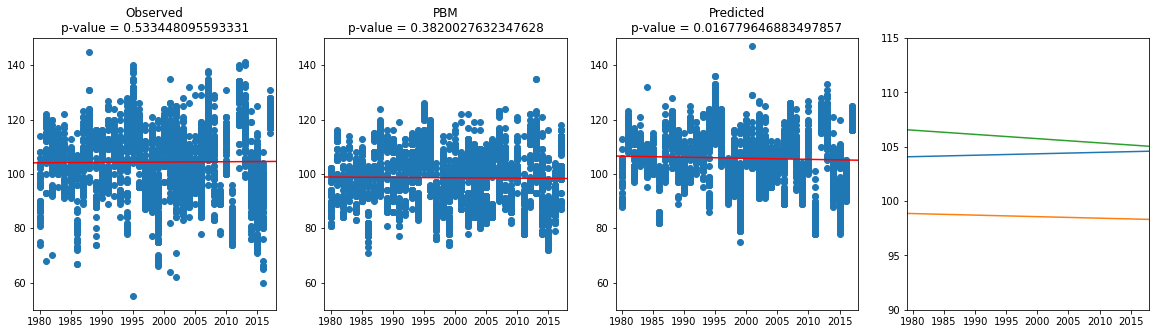

In [17]:
obs_day_of_year_ice_off = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in obs_ice_off
])
flag_day_of_year_ice_off = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in flag_ice_off
])
pred_day_of_year_ice_off = np.asarray([
    datetime.datetime.strptime(str_date, '%Y-%m-%d').timetuple().tm_yday for str_date in pred_ice_off
])

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].scatter(year_of_sequence, obs_day_of_year_ice_off)
ax[1].scatter(year_of_sequence, flag_day_of_year_ice_off)
ax[2].scatter(year_of_sequence, pred_day_of_year_ice_off)

obs_lm = linregress(year_of_sequence, obs_day_of_year_ice_off)
ax[0].axline([0, obs_lm.intercept], slope = obs_lm.slope, zorder = 1, color = 'red')
ax[0].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[0].set_ylim(50, 150)
ax[0].set_title('Observed\np-value = ' + str(obs_lm.pvalue))
print('Observed\n\t', obs_lm)

flag_lm = linregress(year_of_sequence, flag_day_of_year_ice_off)
ax[1].axline([0, flag_lm.intercept], slope = flag_lm.slope, zorder = 1, color = 'red')
ax[1].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[1].set_ylim(50, 150)
ax[1].set_title('PBM\np-value = ' + str(flag_lm.pvalue))
print('\n\nPBM\n\t', flag_lm)

pred_lm = linregress(year_of_sequence, pred_day_of_year_ice_off)
ax[2].axline([0, pred_lm.intercept], slope = pred_lm.slope, zorder = 1, color = 'red')
ax[2].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[2].set_ylim(50, 150)
ax[2].set_title('Predicted\np-value = ' + str(pred_lm.pvalue))
print('\n\nPredicted\n\t', pred_lm)


ax[3].axline([0, obs_lm.intercept], slope = obs_lm.slope, zorder = 1, color = 'tab:blue')
ax[3].axline([0, flag_lm.intercept], slope = flag_lm.slope, zorder = 1, color = 'tab:orange')
ax[3].axline([0, pred_lm.intercept], slope = pred_lm.slope, zorder = 1, color = 'tab:green')
ax[3].set_xlim(min(year_of_sequence) - 1, max(year_of_sequence) + 1)
ax[3].set_ylim(90, 115);

##### With NO process-based inputs

Immediately, it is clear that the ML predictions better match observations than PBM predictions. Even when significance findings differ, overall pattern is better fit using the ML predictions.

We see that linear trend of ice-on date through time is signficant and consistent between observations and ML predictions, where we observe that average ice-on date has gotten about 1 week later over 40 years.

For ice-off, the results are more null, where observations see no change but the predictions expect singificantly (but marginally) earlier ice-off.

In both cases, we thus see that an approximately 1 week increase in ice-free dates

# Spatial distribution

In [18]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':test_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

In [19]:
# Assign all the errors to that newly merged dataframe
# (both are sorted by validation set DOW)
mapping_df['flag_error_ice_on'] = eval_metrics['test_flag_error_ice_on']
mapping_df['flag_error_ice_off'] = eval_metrics['test_flag_error_ice_off']
mapping_df['flag_error_dur']  = eval_metrics['test_flag_error_dur'] 
mapping_df['pred_error_ice_on']  = eval_metrics['test_pred_error_ice_on'] 
mapping_df['pred_error_ice_off'] = eval_metrics['test_pred_error_ice_off'] 
mapping_df['pred_error_dur'] = eval_metrics['test_pred_error_dur']

In [20]:
def map_error(error_col_suffix, jitter):
    # Craft the two column names
    process_based_col = 'flag_' + error_col_suffix
    new_model_col = 'pred_' + error_col_suffix
    
    # Set the colors to map to the same values
    cmap_extreme = np.max(np.abs([mapping_df[new_model_col].min(),
                                  mapping_df[new_model_col].max()]))
    
    # Configure a 2-plot arangement
    fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 0.5]})
    
    # Create the spatial jitter values (same for both subplots)
    lat_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    lon_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    
    # Plot ice flag errors with spatial jitter
    # Size and color are mapped to error
    ax[0].set_title("Process-based Ice Flags")
    ax[0].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[process_based_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[process_based_col])
    
    # Plot new prediction errors with spatial jitter
    # Size and color are mapped to error
    ax[1].set_title("New Model Predictions")
    im = ax[1].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[new_model_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[new_model_col])
    
    # Color legend
    fig.colorbar(im, label = 'Days', cax = ax[2]);

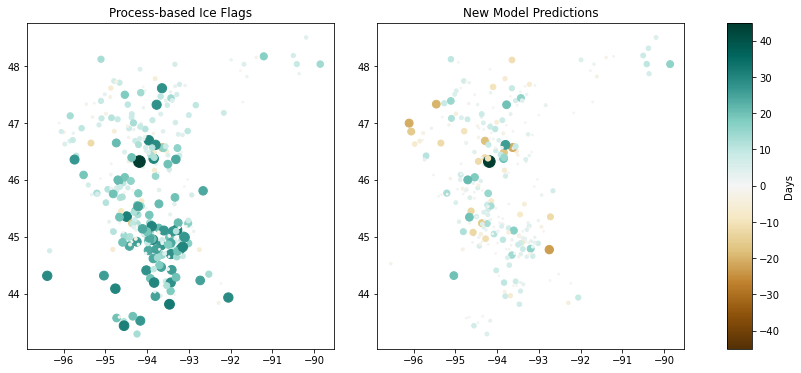

In [21]:
map_error('error_ice_on', 0.2)

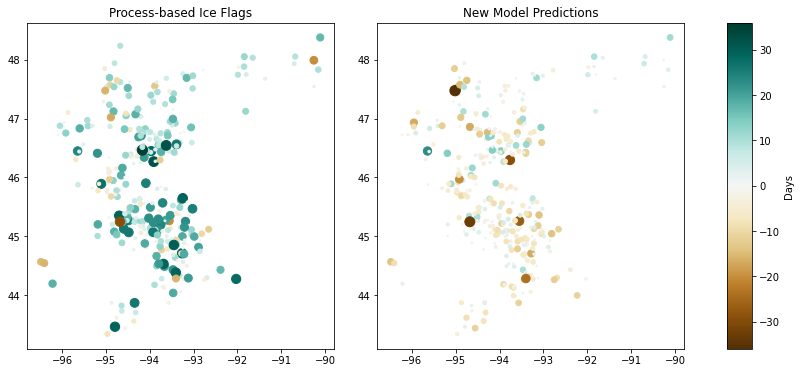

In [22]:
map_error('error_ice_off', 0.2)

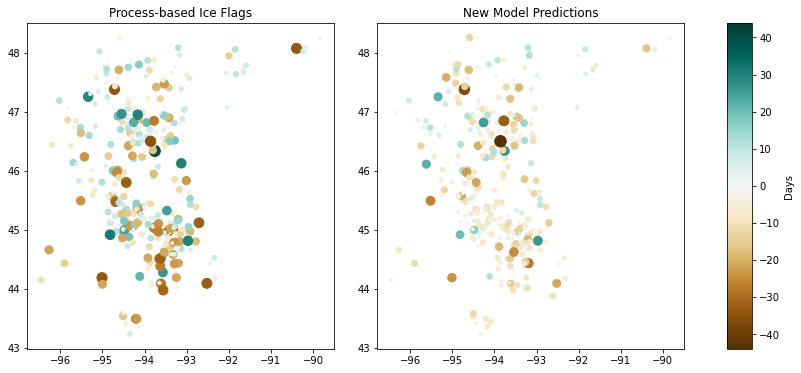

In [23]:
map_error('error_dur', 0.2)

# Do residuals significantly vary with certain lake characteristics?

Some additional evaluation for how residuals change with certain lake characteristics: lat, long, depth, and area. These residual-inspecting plots include a nonlinear correlation and p-value

In [24]:
def plot_and_print_resid_corr(values, label):
    
    # globally accessed mapping_df, assuming its column names (residuals), and associated axis labels
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    
    fig.suptitle('Correlation of Residuals with Static Lake Descriptions')

    ax[0].scatter(values, mapping_df['flag_error_ice_on'], alpha = 0.5, label = 'Process-based')
    ax[1].scatter(values, mapping_df['flag_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['flag_error_dur'], alpha = 0.5)
    ax[0].scatter(values, mapping_df['pred_error_ice_on'], alpha = 0.5, label = 'LSTM')
    ax[1].scatter(values, mapping_df['pred_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['pred_error_dur'], alpha = 0.5)
    ax[0].legend()

    ax[0].set_ylabel('Residual')
    ax[0].set_title('Ice on')
    ax[1].set_title('Ice off')
    ax[1].set_xlabel(label, fontsize = 12)
    ax[2].set_title('Ice duration')
    
    plt.show()

    print('\nProcess-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['flag_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['flag_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['flag_error_dur']))
    print('\nLSTM-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['pred_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['pred_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['pred_error_dur']), '\n')

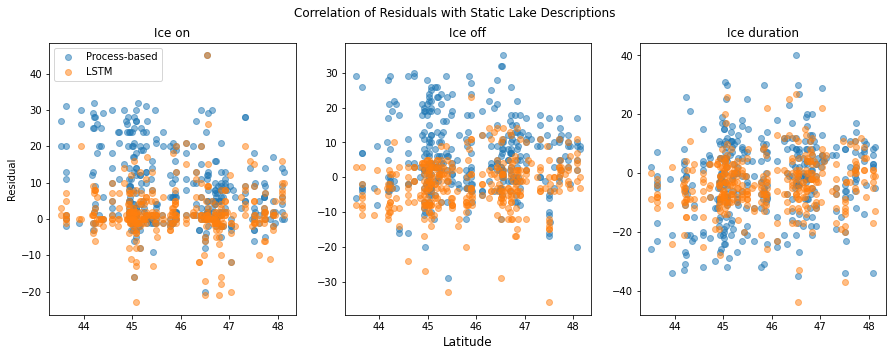


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.23812289257222857, pvalue=6.6722299802438415e-06)
Ice off:	 SpearmanrResult(correlation=0.02034154732154713, pvalue=0.7045145648429307)
Ice duration:	 SpearmanrResult(correlation=0.1921403684762374, pvalue=0.00029976622031457044)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.0009155029679978431, pvalue=0.9863837832244858)
Ice off:	 SpearmanrResult(correlation=0.18213594418196039, pvalue=0.0006171919040906311)
Ice duration:	 SpearmanrResult(correlation=0.16905715746654928, pvalue=0.0015018078835948852) 



In [25]:
plot_and_print_resid_corr(mapping_df['lat'], 'Latitude')

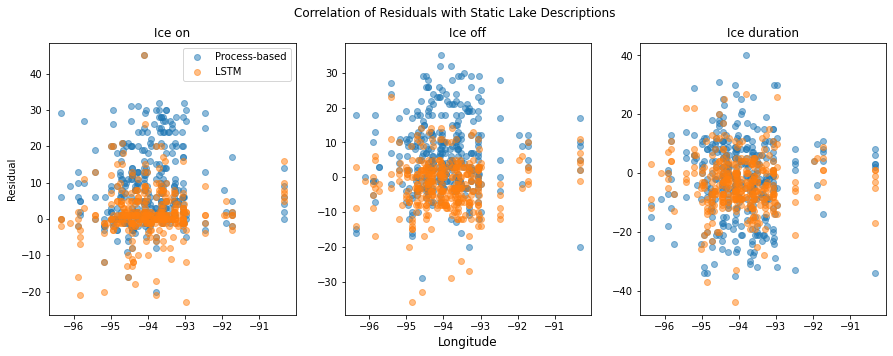


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.12466050507454475, pvalue=0.019650832697652464)
Ice off:	 SpearmanrResult(correlation=0.06681188520962039, pvalue=0.2124495336992866)
Ice duration:	 SpearmanrResult(correlation=-0.046904670176737426, pvalue=0.38165633511906927)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.07645561786694534, pvalue=0.1534857399756523)
Ice off:	 SpearmanrResult(correlation=0.00967235963410575, pvalue=0.8569090711340447)
Ice duration:	 SpearmanrResult(correlation=-0.03525905452989702, pvalue=0.5108715225048921) 



In [26]:
plot_and_print_resid_corr(mapping_df['long'], 'Longitude')

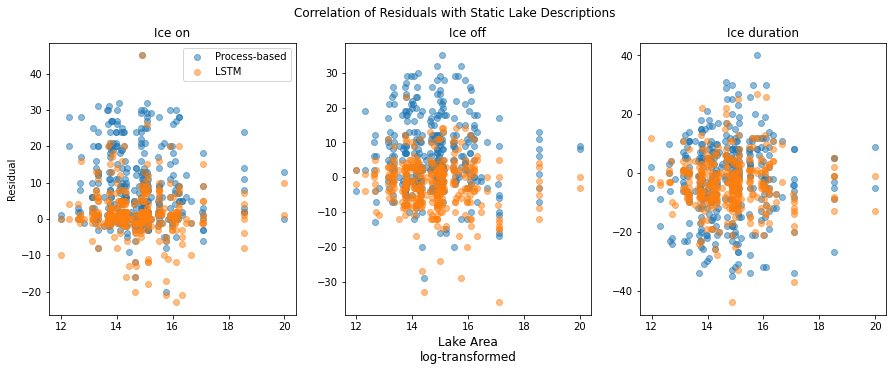


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.09306570289578708, pvalue=0.08209694862366132)
Ice off:	 SpearmanrResult(correlation=0.011216072854286514, pvalue=0.8343784129260337)
Ice duration:	 SpearmanrResult(correlation=0.0672950434739604, pvalue=0.20915392279832182)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.052616831436193126, pvalue=0.32633172460068927)
Ice off:	 SpearmanrResult(correlation=-0.0712462683008036, pvalue=0.183578275226547)
Ice duration:	 SpearmanrResult(correlation=-0.018687064168437056, pvalue=0.7275527601949936) 



In [27]:
areas = test_x[:, 0, area_var_idx]

plot_and_print_resid_corr(areas, 'Lake Area\nlog-transformed')

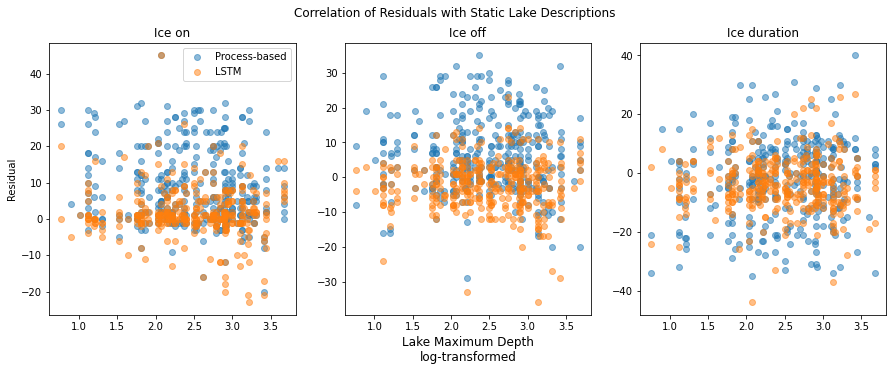


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.1184347297425867, pvalue=0.026719737934237764)
Ice off:	 SpearmanrResult(correlation=-0.04199706358662482, pvalue=0.43349319906774675)
Ice duration:	 SpearmanrResult(correlation=0.06837651189217943, pvalue=0.20191124433502852)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.0033358719444457926, pvalue=0.9504152145993082)
Ice off:	 SpearmanrResult(correlation=-0.03106103273315304, pvalue=0.5624814170324477)
Ice duration:	 SpearmanrResult(correlation=-0.0005395719811859661, pvalue=0.9919747274790861) 



In [28]:
depths = test_x[:, 0, depth_var_idx]

plot_and_print_resid_corr(depths, 'Lake Maximum Depth\nlog-transformed')

## List of significant residual correlations

### With process-based inputs

##### Latitude

* The process-based model's residuals are signficantly correlated with latitude on ice on and ice duration prediction. 
    * Negatively correlated for ice on, positively correlated for ice duration
* The massive lstm's residuals are significantly and positively correlated with latitude on ice off and ice duration prediction.
  
##### Longitude
  
* The process-based model's residuals are significantly and positively correlated with longitude for ice on prediction

##### Lake area

* No significant correlations.
    
##### Lake depth
    
* The process-based model's residuals are significantly and negatively correlated with lake depth on ice on prediction

### In total

* The process-based model's residuals are significantly correlated with static lake descriptions in 4/12 tested scenarios, half of these scenarios involve latitude.
* The massive lstm's residuals are significantly correlated with static lake descriptions in 2/12 tested scenarios, both of these scenarios involve latitude.

### With NO process-based inputs

### In total

* The massive lstm's residuals are significantly correlated with static lake descriptions in 2/12 tested scenarios, both of these scenarios involve latitude.

<br><br><br>

### Paper figure

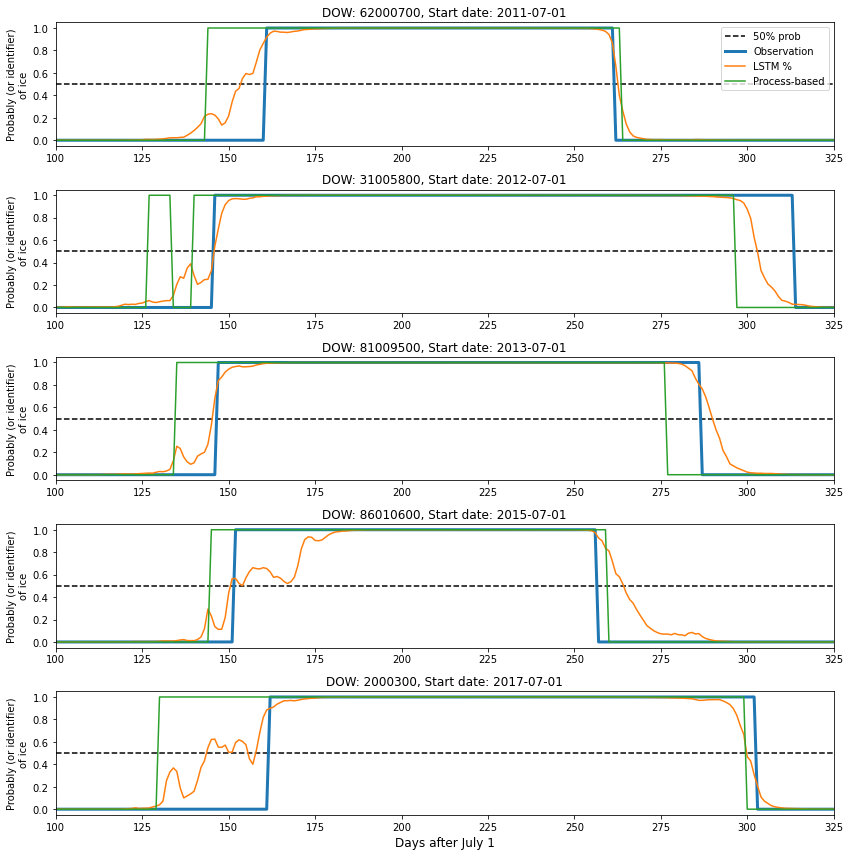

In [29]:
fig, ax = plt.subplots(5, 1, figsize = (12, 12))

count = 0
# different years, different lakes, different behavior
# 264 - pretty clean behavior, lot of improvement
# 148 - improvement but not perfect, displays two PB fall freezes
# 331 - nearly perfect
# 339 - moderate improvement ice on, weakened ice off
# 99 - difficult but improved ice on, equal ice off

for i in [264, 148, 331, 339, 99]:

    ax[count].axhline(0.5, label = '50% prob', linestyle = '--', color = 'black')
    ax[count].plot(test_y[i, :], label = 'Observation', linewidth = 3)
    ax[count].plot(test_preds[i, :, 0], label = 'LSTM %')
    ax[count].plot(test_x[i, :, ice_var_idx], label = 'Process-based')
    ax[count].set_ylabel('Probably (or identifier)\nof ice', fontsize = 10)
    ax[count].set_title('DOW: ' + str(test_DOW[i]) + ', Start date: ' + test_dates[i][0])
    ax[count].set_xlim(100, 325)
    if count == 0:
        ax[count].legend()
    if count == 4:
        ax[count].set_xlabel('Days after July 1', fontsize = 12)
    count += 1

fig.tight_layout()

plt.savefig('../../handpicked_test_timeseries_NoPB.PNG', dpi = 300, bbox_inches = 'tight')